라이브러리

In [1]:
import pandas as pd
import numpy as np
from keras.utils import *
from sklearn.preprocessing import *
from keras import backend as K
from keras.models import load_model
from keras.layers import LSTM, Dense
from keras.models import Sequential
import matplotlib.pyplot as plt
from keras.metrics import mean_squared_error
from sklearn.metrics import r2_score
import matplotlib.font_manager as fm
from matplotlib.dates import DateFormatter
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# 모델명(= 파일명) 설정
tank = 1
model_name = 'reredoRegressor_tank1'

In [2]:
# r_squared 평가 함수
def r_squared(y_true, y_pred):
    ss_res = K.sum(K.square(y_true - y_pred))
    ss_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return (1 - ss_res/(ss_tot + K.epsilon()))

# 모델 평가 함수
def grapeNEva(model, X_test_shape, y_test, feed, y_test_shape):
    X_pred = model.predict(X_test_shape)
    X_pred = np.asarray(X_pred, dtype=np.float64)
    X_pred = X_pred.reshape((-1))
    print(len(X_pred))

    # 그래프 생성
    plt.figure(figsize=(15, 7))
    plt.plot(y_test.index, y_test, label='sensor do')  # x축에 년월일, y축에 값
    plt.plot(y_test.index, X_pred, color='red', label='prediction do')  # x축에 년월일, y축에 시분
    plt.plot(y_test.index, feed, color='green', marker='o', linestyle='None', label='feed_quantity')  # x축에 년월일, y축에 시분
    plt.xlabel('date')
    plt.ylabel('do')
    plt.title(model_name)
    plt.legend(['sensor do','prediction do','feed_quantity'])
    plt.show()
    
    # 평가 생성
    result = model.evaluate(X_test_shape, y_test_shape)
    print("MSE // MAE // R-squared ", result)

In [3]:
# r_squared가 따로 만들어서 추가해준 함수기 때문에 불러올 때도 추가해서 불러야한다.
model = load_model(model_name+'.h5', custom_objects={'r_squared': r_squared})

[[ 1.04765564e-01 -6.39147684e-02  3.47835571e-02 ...  1.08554829e-02
   2.67039444e-02  5.81839867e-02]
 [ 1.21094659e-01 -2.17475984e-02  1.83278155e-02 ... -7.62700886e-02
  -9.72956121e-02  5.33706648e-03]
 [ 2.32230350e-02  2.83456534e-01 -6.80687129e-02 ...  1.54528664e-02
  -8.98696184e-02 -4.60899714e-03]
 ...
 [ 1.04769222e-01  9.27314237e-02  4.04780209e-02 ...  9.49934945e-02
  -1.18427239e-01  3.14676762e-02]
 [-4.09761995e-01 -1.08583939e+00  5.07093146e-02 ...  3.70312780e-02
  -7.47015234e-04 -9.47172865e-02]
 [-3.71967614e-01 -1.10689270e+00  6.33935928e-02 ... -6.58342242e-03
  -1.46214142e-02  6.74764067e-02]]


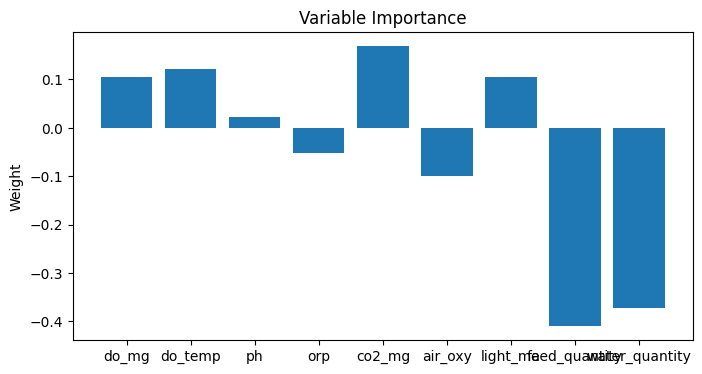

In [4]:
# 가중치를 통해 변수 중요도 획득
weights = model.layers[0].get_weights()[0]
print(weights)


# 변수 중요도 시각화
fig, ax = plt.subplots(figsize=(8, 4))
ax.bar(range(9), weights[:, 0])
ax.set_xticks(range(9))
ax.set_xticklabels(['do_mg', 'do_temp', 'ph', 'orp', 'co2_mg', 'air_oxy', 'light_ma', 'feed_quantity', 'water_quantity'])
ax.set_ylabel('Weight')
ax.set_title('Variable Importance')
plt.show()

In [5]:
#자포니카 검증 데이터
japonica_validation_food_supply_tb = pd.read_csv("E:/kimwoojae/Research/DO Regressor/dataset/japonica_validation_food_supply_tb.csv")
japonica_validation_sensor_val_tb = pd.read_csv("E:/kimwoojae/Research/DO Regressor/dataset/japonica_validation_sensor_val_tb.csv")

#자포니카 사료 공급 데이터 null제거
japonica_validation_food_supply_tb = japonica_validation_food_supply_tb[japonica_validation_food_supply_tb['feed_quantity'].notnull()]

#자포니카 검증 데이터 시계열 변환
japonica_validation_sensor_val_tb["mea_dt"] = japonica_validation_sensor_val_tb["mea_dt"].apply(str)
japonica_validation_sensor_val_tb["mea_dt"] = japonica_validation_sensor_val_tb["mea_dt"].str.slice(start=0, stop=16)
japonica_validation_food_supply_tb['feed_dt'] = pd.to_datetime(japonica_validation_food_supply_tb['feed_dt'], format='%Y%m%d%H%M', errors='raise')
japonica_validation_food_supply_tb["feed_dt"] = japonica_validation_food_supply_tb["feed_dt"].apply(str)
japonica_validation_food_supply_tb["feed_dt"] = japonica_validation_food_supply_tb["feed_dt"].str.slice(start=0, stop=16)

japonica_validation = pd.merge(left = japonica_validation_sensor_val_tb, right = japonica_validation_food_supply_tb, how = "left", left_on = ["farm_id","tank_id", "mea_dt"], right_on = ["farm_id","tank_id", "feed_dt"])
japonica_validation['mea_dt'] = pd.to_datetime(japonica_validation['mea_dt'], format='%Y-%m-%d %H:%M', errors='raise')
japonica_validation_tank = japonica_validation[japonica_validation['tank_id']==tank]

# 사용할 features 선택
feature_origin = ['tank_id','mea_dt', 'do_mg','do_temp', 'ph', 'orp', 'co2_mg', 'air_oxy', 'light_ma', 'feed_quantity', 'water_quantity']
japonica_validation_features = japonica_validation_tank[feature_origin]

# nan 값 처리 (먹이를 주지 않았을 경우는 급여량이 0이니까)
japonica_validation_features = japonica_validation_features.fillna(0)

# 시계열 데이터의 개수 확인
validation_counts = japonica_validation_features.groupby(japonica_validation_features['mea_dt'].dt.date).size()

# 개수가 1440이 아닌 시계열 삭제
to_delete = validation_counts[validation_counts != 1440].index
japonica_validation_data = japonica_validation_features[~japonica_validation_features['mea_dt'].dt.date.isin(to_delete)]

# 날짜 데이터를 인덱스로 전환
japonica_validation_data.set_index('mea_dt', inplace=True)

# 인덱스 순으로 데이터를 정렬
japonica_validation_data = japonica_validation_data.sort_index()

nCar: 359 nVar: 9
nCar: 64620 nVar: 1
nCar: 359 nVar: 180
12/12 [==============================] - 2s 66ms/step
64620


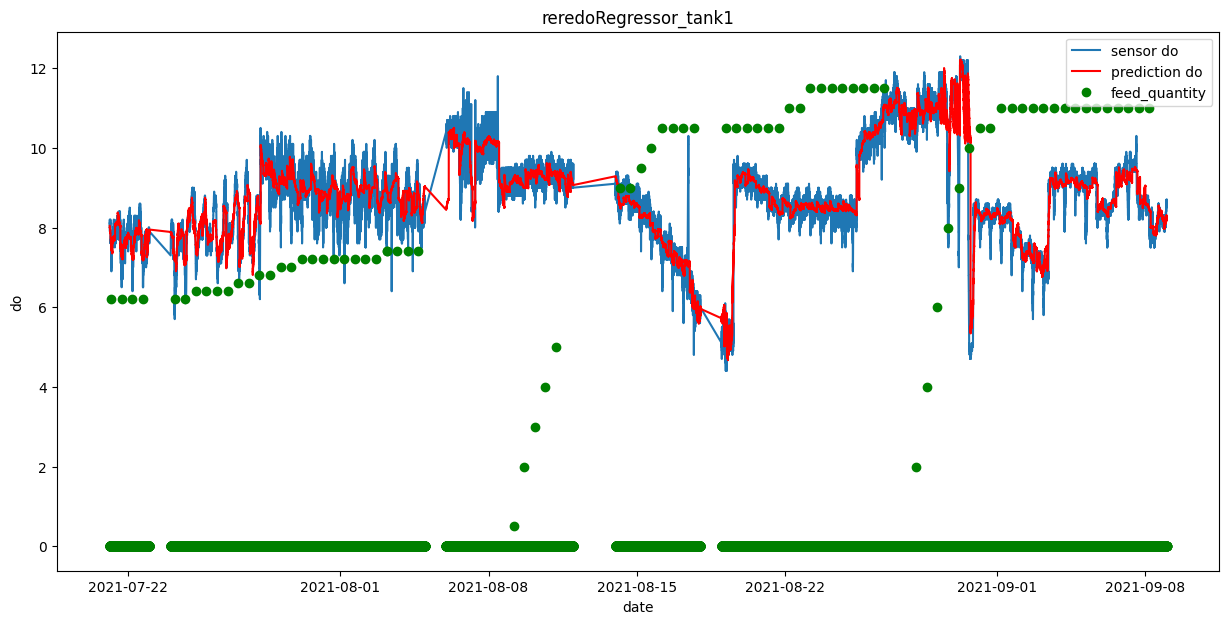

12/12 [==============================] - 2s 60ms/step - loss: 0.2624 - mae: 0.3141 - r_squared: 0.5860
MSE // MAE // R-squared  [0.2623615562915802, 0.3141459822654724, 0.58603435754776]


In [6]:
# 한달 동안의 데이터 추출
one_day_data = japonica_validation_data.loc['2021-07-21 00:00':'2021-09-08 20:59']
oneday_X_test = one_day_data[['do_mg', 'do_temp', 'ph', 'orp', 'co2_mg', 'air_oxy', 'light_ma', 'feed_quantity', 'water_quantity']]
one_day_data = japonica_validation_data.loc['2021-07-21 03:00':'2021-09-08 23:59']
oneday_y_test = one_day_data[['do_mg']]

oneday_X_test_reshape = np.asarray(oneday_X_test, dtype=np.float64)
oneday_X_test_reshape = oneday_X_test_reshape.reshape((-1, 180, 9))
oneday_y_test_reshape = np.asarray(oneday_y_test, dtype=np.float64)
oneday_y_test_reshape = oneday_y_test_reshape.reshape((-1, 180, 1))

# shape확인
nCar = oneday_X_test_reshape.shape[0] # 데이터 개수
nVar = oneday_X_test_reshape.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = oneday_y_test.shape[0] # 데이터 개수
nVar = oneday_y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = oneday_y_test_reshape.shape[0] # 데이터 개수
nVar = oneday_y_test_reshape.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

grapeNEva(model, oneday_X_test_reshape, oneday_y_test, one_day_data[['feed_quantity']], oneday_y_test_reshape)

nCar: 79 nVar: 9
nCar: 14220 nVar: 1
nCar: 79 nVar: 180


3/3 [==============================] - 0s 53ms/step
14220


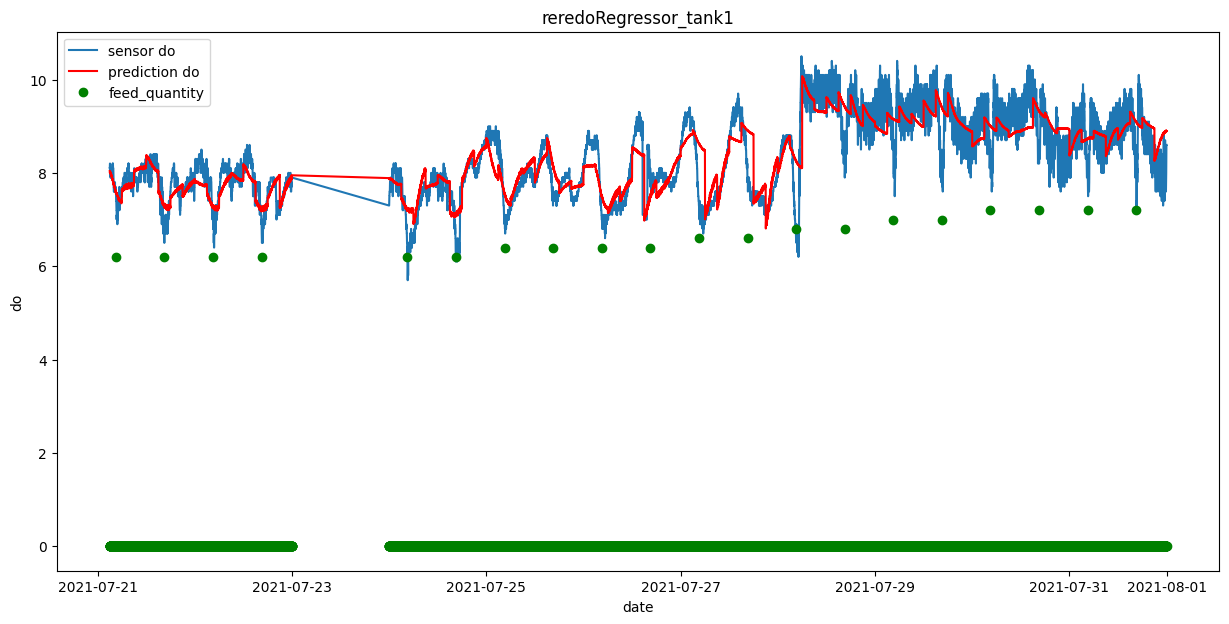

3/3 [==============================] - 0s 58ms/step - loss: 0.2185 - mae: 0.3487 - r_squared: 0.4384
MSE // MAE // R-squared  [0.21848943829536438, 0.3486541211605072, 0.4383963346481323]


In [7]:
# 한주 동안의 데이터 추출
one_day_data = japonica_validation_data.loc['2021-07-21 00:00':'2021-07-31 20:59']
oneday_X_test = one_day_data[['do_mg', 'do_temp', 'ph', 'orp', 'co2_mg', 'air_oxy', 'light_ma', 'feed_quantity', 'water_quantity']]
one_day_data = japonica_validation_data.loc['2021-07-21 03:00':'2021-07-31 23:59']
oneday_y_test = one_day_data[['do_mg']]

oneday_X_test_reshape = np.asarray(oneday_X_test, dtype=np.float64)
oneday_X_test_reshape = oneday_X_test_reshape.reshape((-1, 180, 9))
oneday_y_test_reshape = np.asarray(oneday_y_test, dtype=np.float64)
oneday_y_test_reshape = oneday_y_test_reshape.reshape((-1, 180, 1))

# shape확인
nCar = oneday_X_test_reshape.shape[0] # 데이터 개수
nVar = oneday_X_test_reshape.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = oneday_y_test.shape[0] # 데이터 개수
nVar = oneday_y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = oneday_y_test_reshape.shape[0] # 데이터 개수
nVar = oneday_y_test_reshape.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

grapeNEva(model, oneday_X_test_reshape, oneday_y_test, one_day_data[['feed_quantity']], oneday_y_test_reshape)

nCar: 7 nVar: 9
nCar: 1260 nVar: 1
nCar: 7 nVar: 180


1/1 [==============================] - 0s 72ms/step
1260


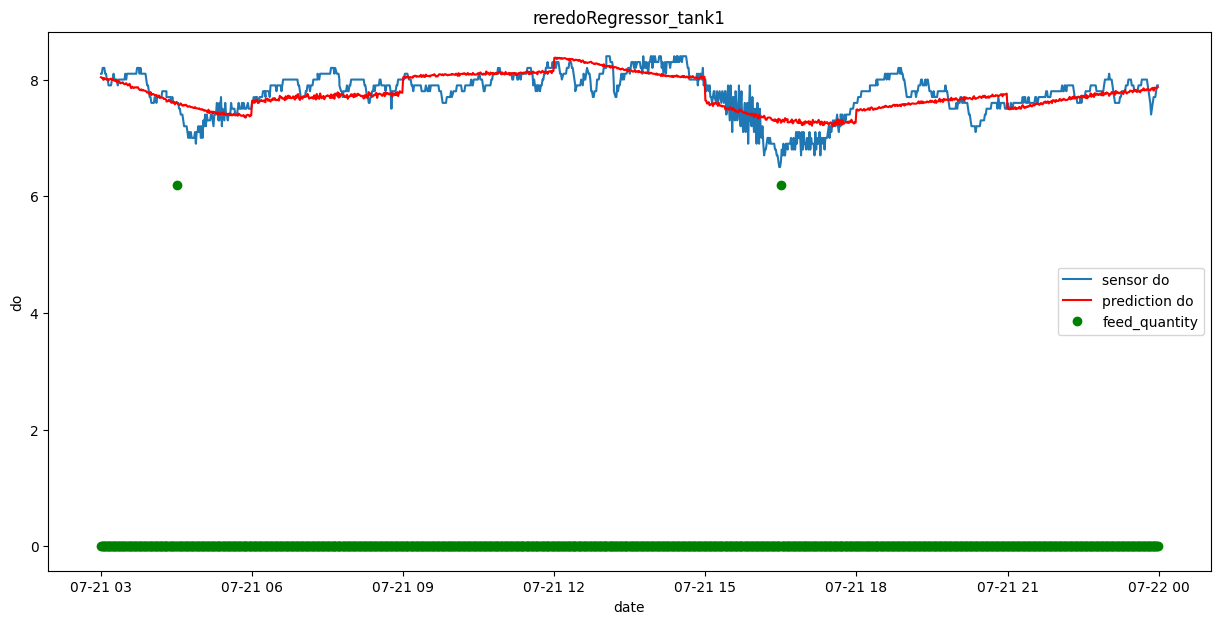

1/1 [==============================] - 0s 66ms/step - loss: 0.0621 - mae: 0.2004 - r_squared: 0.5351
MSE // MAE // R-squared  [0.062083899974823, 0.20040862262248993, 0.5350805521011353]


In [8]:
# 하루 동안의 데이터 추출
one_day_data = japonica_validation_data.loc['2021-07-21 00:00':'2021-07-21 20:59']
oneday_X_test = one_day_data[['do_mg', 'do_temp', 'ph', 'orp', 'co2_mg', 'air_oxy', 'light_ma', 'feed_quantity', 'water_quantity']]
one_day_data = japonica_validation_data.loc['2021-07-21 03:00':'2021-07-21 23:59']
oneday_y_test = one_day_data[['do_mg']]

oneday_X_test_reshape = np.asarray(oneday_X_test, dtype=np.float64)
oneday_X_test_reshape = oneday_X_test_reshape.reshape((-1, 180, 9))
oneday_y_test_reshape = np.asarray(oneday_y_test, dtype=np.float64)
oneday_y_test_reshape = oneday_y_test_reshape.reshape((-1, 180, 1))

# shape확인
nCar = oneday_X_test_reshape.shape[0] # 데이터 개수
nVar = oneday_X_test_reshape.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = oneday_y_test.shape[0] # 데이터 개수
nVar = oneday_y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = oneday_y_test_reshape.shape[0] # 데이터 개수
nVar = oneday_y_test_reshape.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

grapeNEva(model, oneday_X_test_reshape, oneday_y_test, one_day_data[['feed_quantity']], oneday_y_test_reshape)

nCar: 4 nVar: 9
nCar: 720 nVar: 1
nCar: 4 nVar: 180
1/1 [==============================] - 0s 47ms/step
720


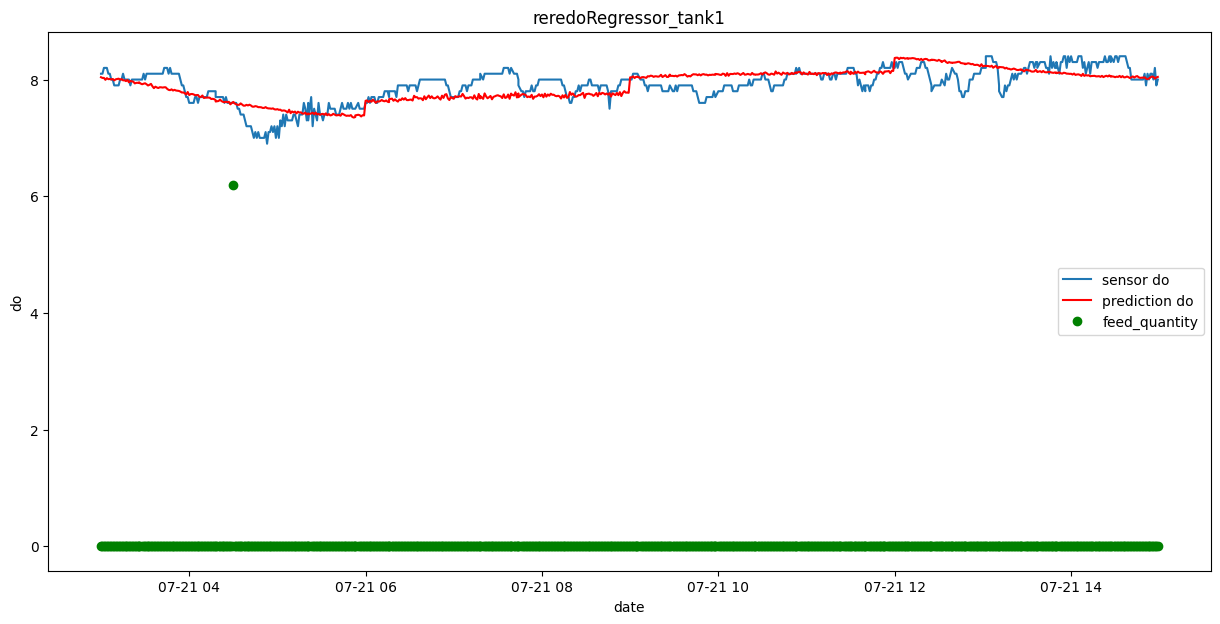

1/1 [==============================] - 0s 51ms/step - loss: 0.0497 - mae: 0.1804 - r_squared: 0.3977
MSE // MAE // R-squared  [0.049658454954624176, 0.18037235736846924, 0.39772117137908936]


In [9]:
# 한 동안의 데이터 추출
one_day_data = japonica_validation_data.loc['2021-07-21 00:00':'2021-07-21 11:59']
oneday_X_test = one_day_data[['do_mg', 'do_temp', 'ph', 'orp', 'co2_mg', 'air_oxy', 'light_ma', 'feed_quantity', 'water_quantity']]
one_day_data = japonica_validation_data.loc['2021-07-21 03:00':'2021-07-21 14:59']
oneday_y_test = one_day_data[['do_mg']]

oneday_X_test_reshape = np.asarray(oneday_X_test, dtype=np.float64)
oneday_X_test_reshape = oneday_X_test_reshape.reshape((-1, 180, 9))
oneday_y_test_reshape = np.asarray(oneday_y_test, dtype=np.float64)
oneday_y_test_reshape = oneday_y_test_reshape.reshape((-1, 180, 1))

# shape확인
nCar = oneday_X_test_reshape.shape[0] # 데이터 개수
nVar = oneday_X_test_reshape.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = oneday_y_test.shape[0] # 데이터 개수
nVar = oneday_y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = oneday_y_test_reshape.shape[0] # 데이터 개수
nVar = oneday_y_test_reshape.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

grapeNEva(model, oneday_X_test_reshape, oneday_y_test, one_day_data[['feed_quantity']], oneday_y_test_reshape)

In [10]:
japonica_validation_data_change1 = japonica_validation_data
japonica_validation_data_change1.at['2021-07-21 08:00', 'feed_quantity'] = 6

nCar: 4 nVar: 9
nCar: 720 nVar: 1
nCar: 4 nVar: 180
1/1 [==============================] - 0s 49ms/step
720


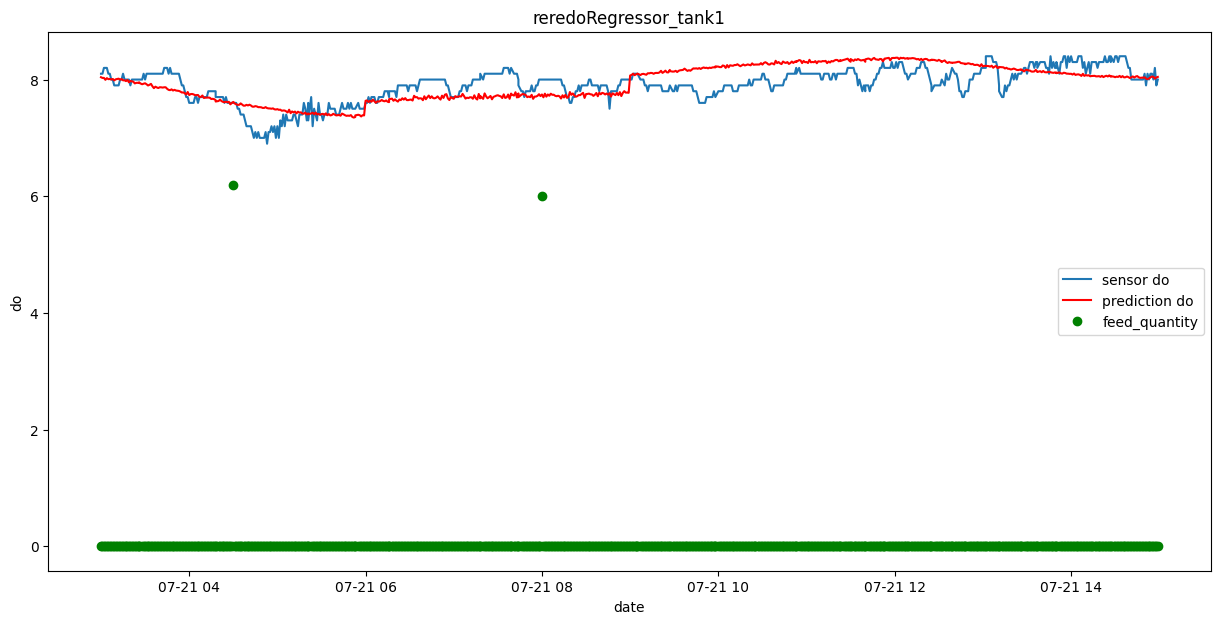

1/1 [==============================] - 0s 51ms/step - loss: 0.0650 - mae: 0.2140 - r_squared: 0.2111
MSE // MAE // R-squared  [0.06504830718040466, 0.21398796141147614, 0.21106642484664917]


In [11]:
# 한 동안의 데이터 추출
one_day_data = japonica_validation_data_change1.loc['2021-07-21 00:00':'2021-07-21 11:59']
oneday_X_test = one_day_data[['do_mg', 'do_temp', 'ph', 'orp', 'co2_mg', 'air_oxy', 'light_ma', 'feed_quantity', 'water_quantity']]
one_day_data = japonica_validation_data_change1.loc['2021-07-21 03:00':'2021-07-21 14:59']
oneday_y_test = one_day_data[['do_mg']]

oneday_X_test_reshape = np.asarray(oneday_X_test, dtype=np.float64)
oneday_X_test_reshape = oneday_X_test_reshape.reshape((-1, 180, 9))
oneday_y_test_reshape = np.asarray(oneday_y_test, dtype=np.float64)
oneday_y_test_reshape = oneday_y_test_reshape.reshape((-1, 180, 1))

# shape확인
nCar = oneday_X_test_reshape.shape[0] # 데이터 개수
nVar = oneday_X_test_reshape.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = oneday_y_test.shape[0] # 데이터 개수
nVar = oneday_y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = oneday_y_test_reshape.shape[0] # 데이터 개수
nVar = oneday_y_test_reshape.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

grapeNEva(model, oneday_X_test_reshape, oneday_y_test, one_day_data[['feed_quantity']], oneday_y_test_reshape)

In [12]:
japonica_validation_data_change2 = japonica_validation_data
japonica_validation_data_change2.at['2021-07-21 04:30', 'feed_quantity'] = japonica_validation_data_change2.at['2021-07-21 04:30', 'feed_quantity'] * 2

nCar: 4 nVar: 9
nCar: 720 nVar: 1
nCar: 4 nVar: 180
1/1 [==============================] - 0s 50ms/step
720


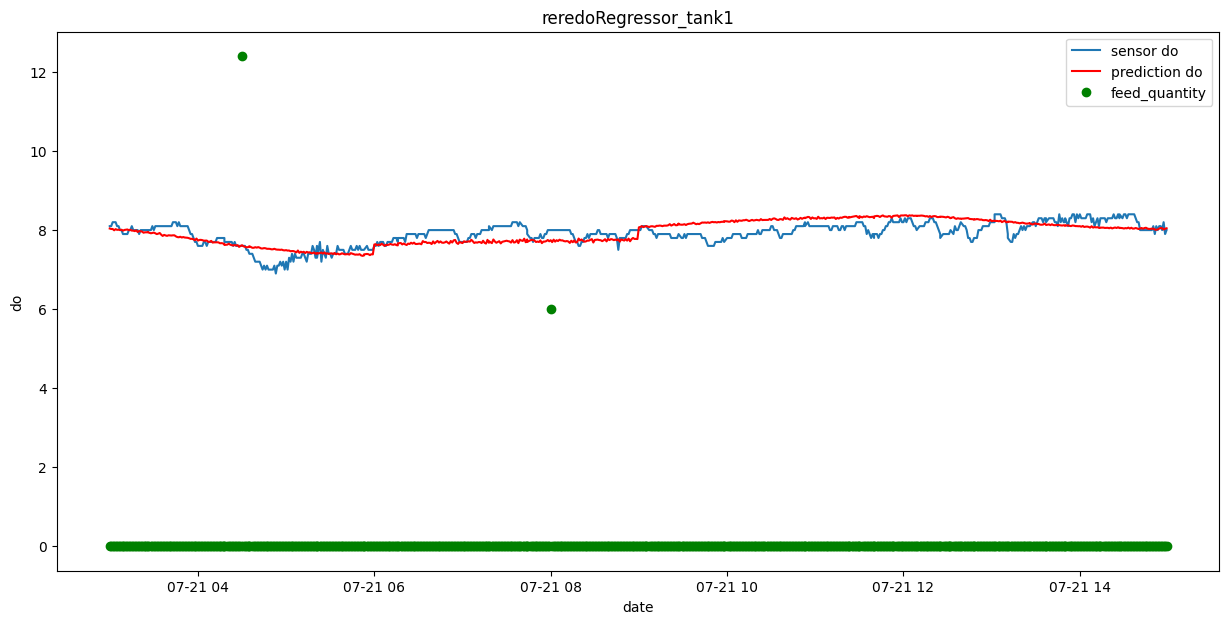

1/1 [==============================] - 0s 54ms/step - loss: 0.0650 - mae: 0.2139 - r_squared: 0.2115
MSE // MAE // R-squared  [0.06501524150371552, 0.21391747891902924, 0.21146756410598755]


In [13]:
# 한 동안의 데이터 추출
one_day_data = japonica_validation_data_change1.loc['2021-07-21 00:00':'2021-07-21 11:59']
oneday_X_test = one_day_data[['do_mg', 'do_temp', 'ph', 'orp', 'co2_mg', 'air_oxy', 'light_ma', 'feed_quantity', 'water_quantity']]
one_day_data = japonica_validation_data_change1.loc['2021-07-21 03:00':'2021-07-21 14:59']
oneday_y_test = one_day_data[['do_mg']]

oneday_X_test_reshape = np.asarray(oneday_X_test, dtype=np.float64)
oneday_X_test_reshape = oneday_X_test_reshape.reshape((-1, 180, 9))
oneday_y_test_reshape = np.asarray(oneday_y_test, dtype=np.float64)
oneday_y_test_reshape = oneday_y_test_reshape.reshape((-1, 180, 1))

# shape확인
nCar = oneday_X_test_reshape.shape[0] # 데이터 개수
nVar = oneday_X_test_reshape.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = oneday_y_test.shape[0] # 데이터 개수
nVar = oneday_y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = oneday_y_test_reshape.shape[0] # 데이터 개수
nVar = oneday_y_test_reshape.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

grapeNEva(model, oneday_X_test_reshape, oneday_y_test, one_day_data[['feed_quantity']], oneday_y_test_reshape)